In [21]:
# ============================================================================
# CELDA 1: IMPORTS Y CONFIGURACIÓN
# ============================================================================
import numpy as np
import pandas as pd
import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_log_error, roc_auc_score
import lightgbm as lgb
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

# Configuración para Jupyter
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configuración de Dask
dask.config.set({"dataframe.convert-string": False})

print("✓ Imports completados")

✓ Imports completados


In [22]:
# ============================================================================
# CELDA 2: CARGAR DATOS
# ============================================================================
dataset_path = "/kaggle/input/smadex-challenge-predict-the-revenue/train"
filters = [("datetime", ">=", "2025-10-01-00-00"), ("datetime", "<", "2025-10-01-05-00")]

print("=" * 80)
print("CARGANDO DATOS CON DASK")
print("=" * 80)

# Leer parquet con Dask
print(f"\n📂 Leyendo desde: {dataset_path}")
if filters:
    print(f"🔍 Aplicando filtros: {filters}")

with ProgressBar():
    ddf = dd.read_parquet(dataset_path, filters=filters)
    
    # Obtener info básica
    n_rows = len(ddf)
    n_cols = len(ddf.columns)

print(f"\n✓ Dataset cargado: {n_rows:,} filas x {n_cols} columnas")
print(f"\n📊 Columnas ({n_cols}):")
for i, col in enumerate(ddf.columns, 1):
    print(f"   {i:2d}. {col}")

# Muestrear datos para análisis
SAMPLE_FRAC = 0.1  # 10% - ajusta según tu memoria
print(f"\n🎲 Muestreando {SAMPLE_FRAC*100:.0f}% para análisis...")

with ProgressBar():
    df_sample = ddf.sample(frac=SAMPLE_FRAC, random_state=42).compute()

print(f"✓ Muestra obtenida: {len(df_sample):,} filas")

CARGANDO DATOS CON DASK

📂 Leyendo desde: /kaggle/input/smadex-challenge-predict-the-revenue/train
🔍 Aplicando filtros: [('datetime', '>=', '2025-10-01-00-00'), ('datetime', '<', '2025-10-01-05-00')]
[########################################] | 100% Completed | 22.42 s

✓ Dataset cargado: 619,768 filas x 85 columnas

📊 Columnas (85):
    1. buyer_d1
    2. buyer_d7
    3. buyer_d14
    4. buyer_d28
    5. buy_d7
    6. buy_d14
    7. buy_d28
    8. iap_revenue_d7
    9. iap_revenue_d14
   10. iap_revenue_d28
   11. registration
   12. retention_d1_to_d7
   13. retention_d3_to_d7
   14. retention_d7_to_d14
   15. retention_d1
   16. retention_d3
   17. retentiond7
   18. advertiser_bundle
   19. advertiser_category
   20. advertiser_subcategory
   21. advertiser_bottom_taxonomy_level
   22. carrier
   23. country
   24. region
   25. dev_make
   26. dev_model
   27. dev_os
   28. dev_osv
   29. hour
   30. release_date
   31. release_msrp
   32. weekday
   33. avg_act_days
   34. avg_da

In [23]:
# ============================================================================
# CELDA 2B: COMPARACIÓN TRAIN VS TEST Y SELECCIÓN DE COLUMNAS COMUNES
# ============================================================================
print("=" * 80)
print("COMPARACIÓN DE DATASETS: TRAIN VS TEST")
print("=" * 80)

# Definir targets (asegúrate de que coincidan con tu dataset)
REVENUE_COL = 'iap_revenue_d7'
BUYER_COL = 'buyer_d7'

# Cargar datos de test (ajusta el path según tu estructura)
test_dataset_path = "/kaggle/input/smadex-challenge-predict-the-revenue/test/test"
test_filters = [("datetime", ">=", "2025-10-01-00-00"), ("datetime", "<", "2025-10-01-05-00")]

print(f"\n📂 Intentando cargar datos de TEST desde: {test_dataset_path}")
try:
    # Verificar si existe ProgressBar, si no, usar contexto simple
    try:
        from dask.diagnostics import ProgressBar
        with ProgressBar():
            ddf_test = dd.read_parquet(test_dataset_path, filters=test_filters)
            n_rows_test = len(ddf_test)
            n_cols_test = len(ddf_test.columns)
    except:
        ddf_test = dd.read_parquet(test_dataset_path, filters=test_filters)
        n_rows_test = len(ddf_test)
        n_cols_test = len(ddf_test.columns)
    
    print(f"✓ Test dataset cargado: {n_rows_test:,} filas x {n_cols_test} columnas")
    
    # Obtener columnas de cada dataset
    train_cols = set(ddf.columns)
    test_cols = set(ddf_test.columns)
    
    # Identificar target columns
    target_cols = {REVENUE_COL, BUYER_COL}
    
    print(f"\n📊 ANÁLISIS DE COLUMNAS:")
    print("=" * 60)
    print(f"   Train: {len(train_cols)} columnas")
    print(f"   Test:  {len(test_cols)} columnas")
    print(f"   Targets identificados: {', '.join(target_cols)}")
    
    # Columnas comunes (excluyendo targets)
    common_cols = (train_cols & test_cols) - target_cols
    
    # Columnas solo en train (incluyendo targets)
    only_train = train_cols - test_cols
    
    # Columnas solo en test
    only_test = test_cols - train_cols

    print(f"\n🔍 DIFERENCIAS:")
    print("=" * 60)
    print(f"   ✅ Columnas comunes (sin targets): {len(common_cols)}")
    print(f"   🔵 Solo en TRAIN: {len(only_train)}")
    print(f"   🟠 Solo en TEST: {len(only_test)}")
    
    if only_train:
        print(f"\n   🔵 Columnas SOLO en TRAIN ({len(only_train)}):")
        for i, col in enumerate(sorted(only_train), 1):
            target_indicator = " ← TARGET" if col in target_cols else ""
            print(f"      {i:2d}. {col}{target_indicator}")
    
    if only_test:
        print(f"\n   🟠 Columnas SOLO en TEST ({len(only_test)}):")
        for i, col in enumerate(sorted(only_test), 1):
            print(f"      {i:2d}. {col}")
    
    # Crear lista de columnas comunes para usar en el modelado
    COMMON_FEATURES = sorted(list(common_cols))
    
    print(f"\n✅ RESULTADO:")
    print("=" * 60)
    print(f"   Variable COMMON_FEATURES creada con {len(COMMON_FEATURES)} columnas")
    print(f"   Estas columnas estarán disponibles en TRAIN y TEST")
    
    # Guardar para referencia
    print(f"\n💾 Primeras 10 columnas comunes:")
    for i, col in enumerate(COMMON_FEATURES[:10], 1):
        print(f"      {i:2d}. {col}")
    
    if len(COMMON_FEATURES) > 10:
        print(f"      ... y {len(COMMON_FEATURES) - 10} más")

except Exception as e:
    print(f"❌ Error al cargar test dataset: {e}")
    print("   Continuando solo con train dataset...")
    COMMON_FEATURES = [col for col in ddf.columns if col not in [REVENUE_COL, BUYER_COL]]

COMPARACIÓN DE DATASETS: TRAIN VS TEST

📂 Intentando cargar datos de TEST desde: /kaggle/input/smadex-challenge-predict-the-revenue/test/test
[########################################] | 100% Completed | 101.83 ms
✓ Test dataset cargado: 0 filas x 68 columnas

📊 ANÁLISIS DE COLUMNAS:
   Train: 85 columnas
   Test:  68 columnas
   Targets identificados: iap_revenue_d7, buyer_d7

🔍 DIFERENCIAS:
   ✅ Columnas comunes (sin targets): 68
   🔵 Solo en TRAIN: 17
   🟠 Solo en TEST: 0

   🔵 Columnas SOLO en TRAIN (17):
       1. buy_d14
       2. buy_d28
       3. buy_d7
       4. buyer_d1
       5. buyer_d14
       6. buyer_d28
       7. buyer_d7 ← TARGET
       8. iap_revenue_d14
       9. iap_revenue_d28
      10. iap_revenue_d7 ← TARGET
      11. registration
      12. retention_d1
      13. retention_d1_to_d7
      14. retention_d3
      15. retention_d3_to_d7
      16. retention_d7_to_d14
      17. retentiond7

✅ RESULTADO:
   Variable COMMON_FEATURES creada con 68 columnas
   Estas column

In [24]:
COMMON_FEATURES = [col for col in COMMON_FEATURES if col in df_sample.columns]
# Agregar targets a COMMON_FEATURES si existen en df_sample original
if REVENUE_COL in df_sample.columns:
    COMMON_FEATURES.append(REVENUE_COL)
if BUYER_COL in df_sample.columns:
    COMMON_FEATURES.append(BUYER_COL)
df_sample = df_sample[COMMON_FEATURES]

In [25]:
# ============================================================================
# CELDA 3: MANEJO DE VALORES FALTANTES (EXCLUYENDO COLUMNAS COMPLEJAS)
# ============================================================================
print("=" * 80)
print("ANÁLISIS Y MANEJO DE VALORES FALTANTES")
print("=" * 80)

from sklearn.impute import SimpleImputer, KNNImputer

# Detectar y excluir columnas complejas (listas, tuplas, dicts, etc.)
print("\n🔍 Detectando columnas complejas a excluir...")
complex_columns = []

for col in df_sample.columns:
    try:
        non_null_values = df_sample[col].dropna()
        if len(non_null_values) > 0:
            first_val = non_null_values.iloc[0]
            if isinstance(first_val, (list, tuple, dict, set)):
                complex_columns.append(col)
    except:
        pass

print(f"⚠️  Columnas complejas encontradas (serán excluidas): {len(complex_columns)}")
if complex_columns:
    print(f"   {complex_columns[:10]}")  # Mostrar primeras 10

# Crear dataframe solo con columnas simples
simple_columns = [col for col in df_sample.columns if col not in complex_columns]
df_simple = df_sample[simple_columns].copy()

print(f"✓ Trabajando con {len(simple_columns)} columnas simples")

# Análisis detallado de missing values (solo columnas simples)
missing = df_simple.isnull().sum()
missing_pct = 100 * missing / len(df_simple)
missing_df = pd.DataFrame({
    'Faltantes': missing,
    'Porcentaje': missing_pct,
    'Tipo': df_simple.dtypes
}).sort_values('Porcentaje', ascending=False)

missing_df = missing_df[missing_df['Faltantes'] > 0]

if len(missing_df) > 0:
    print(f"\n⚠️  Encontradas {len(missing_df)} columnas con valores faltantes:")
    display(missing_df.head(20))
    
    # Categorizar columnas según porcentaje de missing
    high_missing = missing_df[missing_df['Porcentaje'] > 30]
    medium_missing = missing_df[(missing_df['Porcentaje'] > 10) & (missing_df['Porcentaje'] <= 30)]
    low_missing = missing_df[missing_df['Porcentaje'] <= 10]
    
    print(f"\n📊 Categorización por nivel de missing:")
    print(f"   🔴 Alto (>70%): {len(high_missing)} columnas → ELIMINAR")
    print(f"   🟡 Medio (10-70%): {len(medium_missing)} columnas → IMPUTAR CON CUIDADO")
    print(f"   🟢 Bajo (<10%): {len(low_missing)} columnas → IMPUTAR")
    
    # Estrategia de imputación
    print("\n🔧 ESTRATEGIA DE IMPUTACIÓN:")
    print("=" * 60)

    # Eliminar columnas con >70% missing
    cols_to_drop = high_missing.index.tolist()
    if cols_to_drop:
        print(f"\n1. ELIMINAR ({len(cols_to_drop)} columnas con >70% missing):")
        for col in cols_to_drop[:5]:  # Mostrar primeras 5
            print(f"   ❌ {col} ({missing_df.loc[col, 'Porcentaje']:.1f}% missing)")
        df_simple = df_simple.drop(columns=cols_to_drop)
    
    # Imputación para columnas numéricas
    numeric_cols_with_missing = [col for col in low_missing.index.tolist() + medium_missing.index.tolist()
                                 if col in df_simple.columns and df_simple[col].dtype in ['int64', 'float64']]
    
    if numeric_cols_with_missing:
        print(f"\n2. IMPUTAR NUMÉRICAS ({len(numeric_cols_with_missing)} columnas):")
        print("   Estrategia: KNN Imputation (captura relaciones entre variables)")
        
        # Separar por nivel de missing
        low_missing_numeric = [col for col in low_missing.index if col in numeric_cols_with_missing]
        medium_missing_numeric = [col for col in medium_missing.index if col in numeric_cols_with_missing]
        
        # KNN para missing bajo (<10%)
        if low_missing_numeric:
            print(f"\n   2a. KNN(k=5) para {len(low_missing_numeric)} columnas con <10% missing")
            all_numeric = df_simple.select_dtypes(include=[np.number]).columns.tolist()
            knn_imputer_low = KNNImputer(n_neighbors=5, weights='distance')
            df_numeric = df_simple[all_numeric].copy()
            df_imputed = pd.DataFrame(
                knn_imputer_low.fit_transform(df_numeric),
                columns=all_numeric,
                index=df_simple.index
            )
            for col in low_missing_numeric:
                df_simple[col] = df_imputed[col]
        
        # KNN para missing medio (10-70%)
        if medium_missing_numeric:
            print(f"\n   2b. KNN(k=10) para {len(medium_missing_numeric)} columnas con 10-70% missing")
            try:
                all_numeric = df_simple.select_dtypes(include=[np.number]).columns.tolist()
                knn_imputer_medium = KNNImputer(n_neighbors=10, weights='distance')
                df_numeric = df_simple[all_numeric].copy()
                df_imputed = pd.DataFrame(
                    knn_imputer_medium.fit_transform(df_numeric),
                    columns=all_numeric,
                    index=df_simple.index
                )
                for col in medium_missing_numeric:
                    df_simple[col] = df_imputed[col]
            except:
                print(f"       ⚠️  KNN falló, usando MEDIANA")
                for col in medium_missing_numeric:
                    df_simple[col].fillna(df_simple[col].median(), inplace=True)
    
    # Imputación para columnas categóricas
    cat_cols_with_missing = [col for col in low_missing.index.tolist() + medium_missing.index.tolist()
                            if col in df_simple.columns and df_simple[col].dtype == 'object']
    
    if cat_cols_with_missing:
        print(f"\n3. IMPUTAR CATEGÓRICAS ({len(cat_cols_with_missing)} columnas con MODA)")
        for col in cat_cols_with_missing:
            mode_val = df_simple[col].mode()
            if len(mode_val) > 0:
                # Convertir a scalar
                mode_scalar = mode_val.iloc[0]
                df_simple[col].fillna(mode_scalar, inplace=True)
            else:
                df_simple[col].fillna('UNKNOWN', inplace=True)
    
    # Verificar
    remaining_missing = df_simple.isnull().sum().sum()
    if remaining_missing == 0:
        print(f"\n✅ ¡Todos los valores faltantes han sido manejados!")
    else:
        print(f"\n⚠️  Quedan {remaining_missing} valores faltantes")
else:
    print("\n✅ ¡No hay valores faltantes en columnas simples!")

# Actualizar df_sample con columnas procesadas
df_sample = df_simple

ANÁLISIS Y MANEJO DE VALORES FALTANTES

🔍 Detectando columnas complejas a excluir...
⚠️  Columnas complejas encontradas (serán excluidas): 38
   ['advertiser_actions_action_count', 'advertiser_actions_action_last_timestamp', 'avg_daily_sessions', 'avg_duration', 'bcat', 'bcat_bottom_taxonomy', 'bundles_cat', 'bundles_cat_bottom_taxonomy', 'city_hist', 'country_hist']
✓ Trabajando con 32 columnas simples

⚠️  Encontradas 24 columnas con valores faltantes:


,Faltantes,Porcentaje,Tipo
last_advertiser_action,61218,98.775352,object
last_buy,60675,97.899221,float64
avg_days_ins,58616,94.577021,float64
last_ins,52261,84.323217,float64
region,47126,76.037885,object
carrier,46489,75.010084,object
bundles_ins,40309,65.038643,object
new_bundles,33522,54.087807,object
first_request_ts,33522,54.087807,float64
user_bundles,31626,51.028607,object



📊 Categorización por nivel de missing:
   🔴 Alto (>70%): 16 columnas → ELIMINAR
   🟡 Medio (10-70%): 0 columnas → IMPUTAR CON CUIDADO
   🟢 Bajo (<10%): 8 columnas → IMPUTAR

🔧 ESTRATEGIA DE IMPUTACIÓN:

1. ELIMINAR (16 columnas con >70% missing):
   ❌ last_advertiser_action (98.8% missing)
   ❌ last_buy (97.9% missing)
   ❌ avg_days_ins (94.6% missing)
   ❌ last_ins (84.3% missing)
   ❌ region (76.0% missing)

2. IMPUTAR NUMÉRICAS (1 columnas):
   Estrategia: KNN Imputation (captura relaciones entre variables)

   2a. KNN(k=5) para 1 columnas con <10% missing

3. IMPUTAR CATEGÓRICAS (7 columnas con MODA)

✅ ¡Todos los valores faltantes han sido manejados!


In [26]:

# ============================================================================
# CELDA 5: CALCULAR FEATURE IMPORTANCE
# ============================================================================
print("=" * 80)
print("ANÁLISIS DE IMPORTANCIA DE FEATURES")
print("=" * 80)

# Preparar datos - excluir columnas complejas y targets
exclude_cols = [REVENUE_COL, BUYER_COL, 'datetime'] + \
              [col for col in df_sample.columns if 'revenue' in col.lower() or 'buyer' in col.lower()]

# Detectar y excluir columnas con tipos complejos
print("\n🔍 Detectando columnas con tipos complejos a excluir...")
for col in df_sample.columns:
    if col in exclude_cols:
        continue
    try:
        first_non_null = df_sample[col].dropna().iloc[0] if len(df_sample[col].dropna()) > 0 else None
        if first_non_null is not None and isinstance(first_non_null, (list, tuple, dict)):
            exclude_cols.append(col)
            print(f"   • Excluyendo {col} (tipo: {type(first_non_null).__name__})")
    except:
        pass

feature_cols = [col for col in df_sample.columns if col not in exclude_cols]

print(f"\n🔍 Analizando {len(feature_cols)} features")
print(f"   (de {len(df_sample.columns)} columnas totales)")
print(f"   Excluidas: {len(exclude_cols)} columnas")

X = df_sample[feature_cols].copy()
y_revenue = df_sample[REVENUE_COL].values
y_buyer = df_sample[BUYER_COL].values

# Codificar categóricas
print("\n🔤 Codificando features categóricas...")
feature_encoders = {}
X_encoded = X.copy()

for col in X_encoded.columns:
    if X_encoded[col].dtype == 'object':
        try:
            # Intentar label encoding
            le = LabelEncoder()
            X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
            feature_encoders[col] = le
        except Exception as e:
            print(f"   ⚠️  Error codificando {col}: {str(e)[:50]}")
            # Si falla, rellenar con -1
            X_encoded[col] = -1

# Rellenar nulos
X_encoded = X_encoded.fillna(-999)

# Verificar que todos sean numéricos
non_numeric = X_encoded.select_dtypes(exclude=[np.number]).columns
if len(non_numeric) > 0:
    print(f"\n⚠️  Eliminando {len(non_numeric)} columnas no numéricas:")
    for col in non_numeric:
        print(f"   • {col}")
    X_encoded = X_encoded.select_dtypes(include=[np.number])

print(f"\n✓ Features preparados: {X_encoded.shape}")

# Diccionario para almacenar scores
importance_scores = {}

# 1. CORRELACIÓN
print("\n📊 1. Calculando correlaciones con target...")
correlations = X_encoded.corrwith(pd.Series(y_revenue)).abs().sort_values(ascending=False)
print("\n   Top 10 features por correlación:")
display(correlations.head(10))
importance_scores['correlation'] = correlations

# 2. MUTUAL INFORMATION
print("\n🔗 2. Calculando Mutual Information...")
mi_scores = mutual_info_regression(X_encoded, y_revenue, random_state=42)
mi_series = pd.Series(mi_scores, index=X_encoded.columns).sort_values(ascending=False)
print("\n   Top 10 features por MI:")
display(mi_series.head(10))
importance_scores['mutual_info'] = mi_series

# 3. LIGHTGBM BUYER MODEL
print("\n🌳 3. Entrenando LightGBM para predicción de compradores...")
X_train, X_val, y_buy_train, y_buy_val = train_test_split(
    X_encoded, y_buyer, test_size=0.2, random_state=42, stratify=y_buyer
)

lgb_buyer = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    verbose=-1,
    n_jobs=-1
)
lgb_buyer.fit(X_train, y_buy_train)

buyer_importance = pd.Series(
    lgb_buyer.feature_importances_,
    index=X_encoded.columns
).sort_values(ascending=False)

buyer_preds = lgb_buyer.predict_proba(X_val)[:, 1]
buyer_auc = roc_auc_score(y_buy_val, buyer_preds)

print(f"   ✓ Buyer Model AUC: {buyer_auc:.4f}")
print("\n   Top 10 features para buyer:")
display(buyer_importance.head(10))
importance_scores['lgb_buyer'] = buyer_importance

# 4. LIGHTGBM REVENUE MODEL
print("\n💰 4. Entrenando LightGBM para predicción de revenue (solo compradores)...")
buyer_mask = y_buyer == 1

if buyer_mask.sum() > 100:
    X_buyers = X_encoded[buyer_mask]
    y_rev_buyers = y_revenue[buyer_mask]
    
    X_buy_train, X_buy_val, y_rev_train, y_rev_val = train_test_split(
        X_buyers, y_rev_buyers, test_size=0.2, random_state=42
    )
    
    lgb_revenue = lgb.LGBMRegressor(
        n_estimators=100,
        max_depth=8,
        learning_rate=0.05,
        random_state=42,
        verbose=-1,
        n_jobs=-1
    )
    lgb_revenue.fit(X_buy_train, np.log1p(y_rev_train))
    
    revenue_importance = pd.Series(
        lgb_revenue.feature_importances_,
        index=X_encoded.columns
    ).sort_values(ascending=False)
    
    print("\n   Top 10 features para revenue:")
    display(revenue_importance.head(10))
    importance_scores['lgb_revenue'] = revenue_importance
else:
    print("   ⚠️  No hay suficientes compradores para entrenar modelo de revenue")

print("\n✓ Análisis de importancia completado")

ANÁLISIS DE IMPORTANCIA DE FEATURES

🔍 Detectando columnas con tipos complejos a excluir...

🔍 Analizando 13 features
   (de 16 columnas totales)
   Excluidas: 5 columnas

🔤 Codificando features categóricas...

✓ Features preparados: (61977, 13)

📊 1. Calculando correlaciones con target...

   Top 10 features por correlación:


advertiser_bundle         0.007618
advertiser_subcategory    0.007592
country                   0.007277
dev_model                 0.006040
row_id                    0.005717
hour                      0.004786
release_msrp              0.003435
advertiser_category       0.002493
dev_make                  0.002345
dev_osv                   0.001981
dtype: float64


🔗 2. Calculando Mutual Information...

   Top 10 features por MI:


advertiser_bundle         0.059276
advertiser_subcategory    0.035290
advertiser_category       0.025841
country                   0.024170
release_msrp              0.023433
dev_model                 0.017088
dev_osv                   0.015916
release_date              0.011370
dev_make                  0.008407
dev_os                    0.008270
dtype: float64


🌳 3. Entrenando LightGBM para predicción de compradores...
   ✓ Buyer Model AUC: 0.8734

   Top 10 features para buyer:


advertiser_bundle         480
release_msrp              429
row_id                    361
country                   278
dev_model                 274
advertiser_subcategory    241
release_date              208
dev_osv                   205
advertiser_category       181
dev_make                  124
dtype: int32


💰 4. Entrenando LightGBM para predicción de revenue (solo compradores)...

   Top 10 features para revenue:


advertiser_bundle         517
row_id                    367
advertiser_subcategory    319
release_msrp              311
country                   300
dev_model                 225
advertiser_category       185
release_date              184
dev_osv                   126
dev_make                   83
dtype: int32


✓ Análisis de importancia completado


AGREGACIÓN Y SELECCIÓN DE FEATURES

📋 Top 30 Features (agregados):


,Feature,Score
0,advertiser_bundle,1.000000
1,advertiser_subcategory,0.677749
2,country,0.630609
3,release_msrp,0.585373
4,row_id,0.555929
5,dev_model,0.521785
6,advertiser_category,0.374539
7,dev_osv,0.299836
8,release_date,0.262668
9,hour,0.241510



✅ Seleccionados: 13 features
❌ Descartados: 0 features
📉 Reducción: 13 → 13 (100.0%)


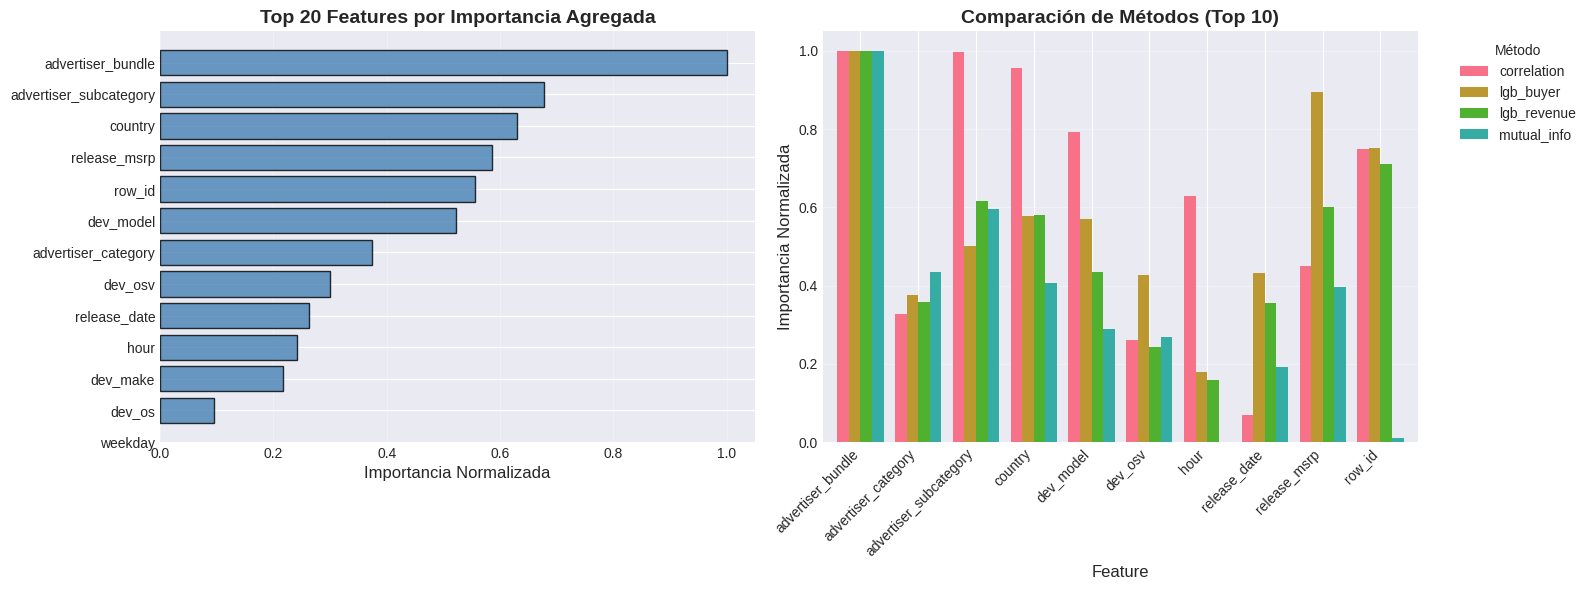


✓ Visualización guardada en 'feature_importance.png'


In [27]:
# ============================================================================
# CELDA 6: AGREGAR Y SELECCIONAR TOP FEATURES
# ============================================================================
print("=" * 80)
print("AGREGACIÓN Y SELECCIÓN DE FEATURES")
print("=" * 80)

N_TOP_FEATURES = 30  # Ajusta este número según necesites

# Normalizar y agregar scores
all_features = X_encoded.columns
aggregated = {}

for feature in all_features:
    scores = []
    for method, importance_series in importance_scores.items():
        if feature in importance_series.index:
            score = importance_series[feature]
            max_score = importance_series.max()
            if max_score > 0:
                scores.append(score / max_score)
    
    if scores:
        aggregated[feature] = np.mean(scores)

aggregated_series = pd.Series(aggregated).sort_values(ascending=False)

print(f"\n📋 Top {N_TOP_FEATURES} Features (agregados):")
display(pd.DataFrame({
    'Feature': aggregated_series.head(N_TOP_FEATURES).index,
    'Score': aggregated_series.head(N_TOP_FEATURES).values
}).reset_index(drop=True))

# Seleccionar top features
selected_features = aggregated_series.head(N_TOP_FEATURES).index.tolist()
dropped_features = [f for f in all_features if f not in selected_features]

print(f"\n✅ Seleccionados: {len(selected_features)} features")
print(f"❌ Descartados: {len(dropped_features)} features")
print(f"📉 Reducción: {len(all_features)} → {len(selected_features)} ({len(selected_features)/len(all_features)*100:.1f}%)")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 20 features
top_20 = aggregated_series.head(20)
axes[0].barh(range(len(top_20)), top_20.values, color='steelblue', edgecolor='black', alpha=0.8)
axes[0].set_yticks(range(len(top_20)))
axes[0].set_yticklabels(top_20.index, fontsize=10)
axes[0].set_xlabel('Importancia Normalizada', fontsize=12)
axes[0].set_title('Top 20 Features por Importancia Agregada', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Comparación de métodos para top 10
top_10_features = aggregated_series.head(10).index
comparison_data = []

for method, importance_series in importance_scores.items():
    for feat in top_10_features:
        if feat in importance_series.index:
            score = importance_series[feat]
            max_score = importance_series.max()
            comparison_data.append({
                'Feature': feat,
                'Method': method,
                'Score': score / max_score if max_score > 0 else 0
            })

comparison_df = pd.DataFrame(comparison_data)
comparison_pivot = comparison_df.pivot(index='Feature', columns='Method', values='Score')

comparison_pivot.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_xlabel('Feature', fontsize=12)
axes[1].set_ylabel('Importancia Normalizada', fontsize=12)
axes[1].set_title('Comparación de Métodos (Top 10)', fontsize=14, fontweight='bold')
axes[1].legend(title='Método', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(axis='y', alpha=0.3)
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualización guardada en 'feature_importance.png'")